In [30]:
# データ分析用のライブラリをインポート
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import glob
from IPython.display import display, Image
import pickle
import random

import PIL.Image

# カラム全表示
pd.set_option('max_columns',None)

# 小数点の設定
%precision 5

'%.5f'

In [2]:
from logging import getLogger, StreamHandler, DEBUG, FileHandler, Formatter
logger = getLogger(__name__)
sthandler = StreamHandler()
sthandler.setLevel(DEBUG)

filehandler = FileHandler("model_training.log")
filehandler.setLevel(DEBUG)

formatter = Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
filehandler.setFormatter(formatter)
sthandler.setFormatter(formatter)

logger.addHandler(sthandler)
logger.addHandler(filehandler)
logger.setLevel(DEBUG)
logger.propagate = False

logger.debug('hello')

2018-07-14 11:07:43,496:18:DEBUG:hello


In [3]:
import keras
import json
from keras.models import model_from_json
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Model
from keras.layers import Dense
from keras.preprocessing import image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# model = ResNet50(weights='imagenet')
# model = Xception(weights='imagenet')

In [20]:
# AVAデータセットを読み込む
columns = ["Index", "ImageId"] + [i+1 for i in range(10)] + ["SemTag_1", "SemTag_2"] + ["ChallengeID"]
AVA = pd.read_table("../AVA_dataset/AVA.txt", sep=" ", header=None)
AVA.columns = columns
AVA.head()

# 各画像のMOSを算出する
eval_array = AVA[[i+1 for i in range(10)]].values
eval_sum = np.dot(eval_array, (np.arange(10) + 1))
MOS = eval_sum / eval_array.sum(axis=1)
AVA["MOS"] = MOS

# 画像の入っているパスを指定する
image_path = "../images/"
file_names = glob.glob(image_path+"*.jpg")

# データセットに入っているデータだけを持ってくる
df = pd.DataFrame(file_names, columns=["ImageId"])
df["ImageId"] = df["ImageId"].map(lambda x : x.split("/")[-1].split(".")[0])
image_ids = df["ImageId"].values

AVA = AVA[AVA["ImageId"].isin(image_ids)]

In [21]:
AVA.head()

,Index,ImageId,1,2,3,4,5,6,7,8,9,10,SemTag_1,SemTag_2,ChallengeID,MOS
10,11,953417,0,0,0,5,32,50,23,10,3,1,22,0,1396,6.112903
11,12,953777,0,3,2,3,13,40,35,21,8,3,20,53,1396,6.593750
12,13,953756,0,2,3,9,35,50,20,5,2,2,0,0,1396,5.796875
13,14,954195,0,1,7,26,56,23,6,1,0,2,0,0,1396,5.040984
14,15,953903,0,1,4,5,33,50,17,9,3,2,21,28,1396,5.943548


In [22]:
# train, testを分ける
train_img_path = np.random.choice(image_ids, size=int(len(file_names) * 0.7), replace=False)
test_img_path = AVA[~AVA["ImageId"].isin(train_img_path)]["ImageId"].values

In [23]:
Y_train_min = AVA[AVA["ImageId"].isin(train_img_path)]["MOS"].min()
Y_train_max = AVA[AVA["ImageId"].isin(train_img_path)]["MOS"].max()

In [24]:
np.random.shuffle(train_img_path)

In [26]:
base_model = Xception(weights='imagenet', include_top=False, pooling="max")
x = base_model.output
# x = Dense(2048, activation="tanh", kernel_initializer="truncated_normal")(x)
predictions = Dense(1, activation="linear", kernel_initializer="truncated_normal")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# base_modelのパラメータは学習しないようにする
for layer in base_model.layers:
    layer.trainable = False

# 最適化手法を指定
model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの保存
json_string = model.to_json()
with open('models/IQA_model.pickle', mode='wb') as f:
    pickle.dump(json_string, f)

# model.load_weights('weights/IQA_model_weight.hdf5')

In [11]:
# with open('models/IQA_model.pickle', mode='rb') as f:
#     model = model_from_json(pickle.load(f))
#     model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [ ]:
# 乱数の固定
random.seed(100)
np.random.seed(100)

num_epochs = 10
batch_size = 500
num_unit = int(np.ceil(len(train_img_path) / batch_size))

for i in range(num_epochs):
    logger.debug("-------- starting "+str(i+1)+" th epoch --------")
    # epochs毎に学習データをシャッフルする
    np.random.shuffle(train_img_path)
    for j in range(num_unit):
        logger.debug(str(i+1)+" th epoch - "+str(j+1)+"/"+str(num_unit)+" th train data")
        # 一度に全ての画像を載せられないので分割しながら学習する
        sub_train_img_path = train_img_path[j*batch_size:(j+1)*batch_size]
        tmp = AVA[AVA["ImageId"].isin(sub_train_img_path)]
        tmp = tmp.sort_values(by="ImageId")
        sub_train_img_path = tmp["ImageId"].values
        
        X_train = []
        for img_path in sub_train_img_path:
            img_path = image_path+str(img_path)+".jpg"
            img = image.load_img(img_path, target_size=(224, 224))
            X_train.append(preprocess_input(image.img_to_array(img)))
        X_train = np.array(X_train)
        Y_train = tmp["MOS"].values
        Y_train = (Y_train - Y_train_min) / (Y_train_max - Y_train_min)

        # モデルの学習
        model.fit(x=X_train, y=Y_train, batch_size=250, epochs=1, verbose=2, callbacks=None, shuffle=True)
        loss = model.evaluate(x=X_train, y=Y_train, batch_size=100, verbose=0)
        logger.debug("loss : "+str(loss))
        if j % 40 == 0:
            # 10batchごとにモデルの値を保存する
            model.save_weights('weights/IQA_model_weight_'+str(j)+'.hdf5')
    # 1epochごとにモデルの値を保存する
    model.save_weights('weights/IQA_model_weight_epoch'+str(i+1)+'.hdf5')

2018-07-15 11:53:24,490:10:DEBUG:-------- starting 1 th epoch --------
2018-07-15 11:53:24,495:14:DEBUG:1 th epoch - 1/305 th train data


Epoch 1/1
 - 5s - loss: 0.0116


2018-07-15 11:53:40,044:33:DEBUG:loss : 3.6971967220306396
2018-07-15 11:53:40,414:14:DEBUG:1 th epoch - 2/305 th train data


Epoch 1/1
 - 5s - loss: 0.0120


2018-07-15 11:53:55,905:33:DEBUG:loss : 4.341156339645385
2018-07-15 11:53:55,906:14:DEBUG:1 th epoch - 3/305 th train data


Epoch 1/1
 - 5s - loss: 0.0118


2018-07-15 11:54:11,532:33:DEBUG:loss : 2.2037558555603027
2018-07-15 11:54:11,533:14:DEBUG:1 th epoch - 4/305 th train data


Epoch 1/1
 - 5s - loss: 0.0111


2018-07-15 11:54:27,203:33:DEBUG:loss : 5.2555547714233395
2018-07-15 11:54:27,204:14:DEBUG:1 th epoch - 5/305 th train data


Epoch 1/1
 - 5s - loss: 0.0133


2018-07-15 11:54:42,679:33:DEBUG:loss : 2.0222262859344484
2018-07-15 11:54:42,680:14:DEBUG:1 th epoch - 6/305 th train data


Epoch 1/1
 - 5s - loss: 0.0116


2018-07-15 11:54:58,284:33:DEBUG:loss : 3.1054960250854493
2018-07-15 11:54:58,285:14:DEBUG:1 th epoch - 7/305 th train data


Epoch 1/1
 - 5s - loss: 0.0126


2018-07-15 11:55:13,840:33:DEBUG:loss : 5.202500200271606
2018-07-15 11:55:13,841:14:DEBUG:1 th epoch - 8/305 th train data


Epoch 1/1
 - 5s - loss: 0.0133


2018-07-15 11:55:29,336:33:DEBUG:loss : 2.781489849090576
2018-07-15 11:55:29,336:14:DEBUG:1 th epoch - 9/305 th train data


Epoch 1/1
 - 5s - loss: 0.0122


2018-07-15 11:55:44,987:33:DEBUG:loss : 1.883478593826294
2018-07-15 11:55:44,988:14:DEBUG:1 th epoch - 10/305 th train data
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Epoch 1/1
 - 5s - loss: 0.0117


2018-07-15 11:56:00,687:33:DEBUG:loss : 3.7522615432739257
2018-07-15 11:56:00,689:14:DEBUG:1 th epoch - 11/305 th train data
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11046 bytes but only got 749. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9664 bytes but only got 749. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag))


Epoch 1/1
 - 5s - loss: 0.0107


2018-07-15 11:56:16,492:33:DEBUG:loss : 2.957422065734863
2018-07-15 11:56:16,493:14:DEBUG:1 th epoch - 12/305 th train data


Epoch 1/1
 - 5s - loss: 0.0108


2018-07-15 11:56:32,269:33:DEBUG:loss : 2.7823687553405763
2018-07-15 11:56:32,270:14:DEBUG:1 th epoch - 13/305 th train data


Epoch 1/1
 - 5s - loss: 0.0106


2018-07-15 11:56:47,937:33:DEBUG:loss : 1.6539708852767945
2018-07-15 11:56:47,938:14:DEBUG:1 th epoch - 14/305 th train data


Epoch 1/1
 - 5s - loss: 0.0103


2018-07-15 11:57:03,494:33:DEBUG:loss : 4.229600667953491
2018-07-15 11:57:03,495:14:DEBUG:1 th epoch - 15/305 th train data
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 842019120 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 207302 bytes but only got 675. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


Epoch 1/1
 - 5s - loss: 0.0125


2018-07-15 11:57:19,128:33:DEBUG:loss : 3.270713233947754
2018-07-15 11:57:19,130:14:DEBUG:1 th epoch - 16/305 th train data


Epoch 1/1
 - 5s - loss: 0.0113


2018-07-15 11:57:34,792:33:DEBUG:loss : 4.005846166610718
2018-07-15 11:57:34,793:14:DEBUG:1 th epoch - 17/305 th train data


Epoch 1/1
 - 5s - loss: 0.0106


2018-07-15 11:57:50,450:33:DEBUG:loss : 1.7925853252410888
2018-07-15 11:57:50,451:14:DEBUG:1 th epoch - 18/305 th train data


Epoch 1/1


In [32]:
# 1epochsごとにモデルの値を保存する
# model.save_weights('weights/IQA_model_weight.hdf5')
model.load_weights('weights/IQA_model_weight_epoch10.hdf5')

In [35]:
# for j in range(5):
#     print(file_names[j])
#     model.load_weights(file_names[j])
for i in range(5):
    img_id = np.random.choice(train_img_path)
    img_path = image_path+str(img_id)+".jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    x_test = preprocess_input(image.img_to_array(img))
    x_test = np.expand_dims(x_test, axis=0)
    print(model.predict(x_test))
    print(AVA[AVA["ImageId"] == int(img_id)]["MOS"].values)   

[[6.41715]]
[4.92093]
[[1.15913]]
[5.69048]
[[1.54277]]
[6.02395]
[[2.88617]]
[5.35573]
[[4.01108]]
[5.82222]


In [181]:
for i in range(5):
    img_id = np.random.choice(train_img_path)
    img_path = "images/"+str(img_id)+".jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    x_test = preprocess_input(image.img_to_array(img))
    x_test = np.expand_dims(x_test, axis=0)
    print(model.predict(x_test))
    print(AVA[AVA["ImageId"] == int(img_id)]["MOS"].values)

1.0

In [159]:
Y_train[0] * (Y_max - Y_min) + Y_min

6.402684563758388

In [160]:
model.predict(x_test) * (Y_max - Y_min) + Y_min

array([[16.90364]], dtype=float32)

In [132]:
Y_train.mean()

1.5631940186722203e-16

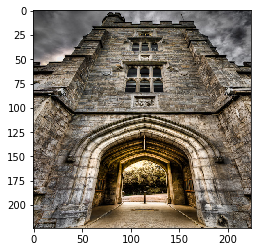

In [67]:
img_path = test_img_path[0]
img_path = "images/"+str(img_path)+".jpg"
img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
x_test = image.img_to_array(img)
x_test = preprocess_input(x_test)
x_test = np.expand_dims(x_test, axis=0)

In [34]:
model.predict(x_test)

array([953619, 953958, 954184, ...,  56711,  57303,  57221])